In [40]:
import numpy as np
import matplotlib.pyplot as plt
from bandits_utils import *

In [67]:
def generate_matrix(n_users, n_movies, prob) :
    # We fill in the matrix with a non-null value with probability prob to obtain a scarce matrix
    Ratings = []
    for i in range(n_users*n_movies):
        if np.random.random()>prob :
            Ratings.append(0)
        else : 
            Ratings.append(np.random.randint(1,6))
    Ratings = np.array(Ratings).reshape((n_users,n_movies))
    return Ratings

In [68]:
R = generate_matrix(30,60,0.6)
R

array([[5, 2, 4, ..., 0, 1, 3],
       [1, 0, 0, ..., 0, 1, 0],
       [5, 1, 2, ..., 1, 4, 0],
       ...,
       [1, 0, 5, ..., 1, 5, 0],
       [5, 0, 2, ..., 2, 3, 5],
       [3, 4, 2, ..., 4, 0, 0]])

$$R \sim U \cdot M$$

In [69]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF

def fill_matrix_MF(ratings, d, max_iter = 1000):
    """
    Returns a predicted matrix using matrix factorization to deal with zeros(non rated movies)
    """

    model = NMF(n_components=d, init='random', random_state=0, max_iter = max_iter)

    U = model.fit_transform(R)
    M = model.components_

    return U@M

In [70]:
fill_matrix_MF(R,3)

array([[2.27788736, 1.0821339 , 2.12901772, ..., 1.60818416, 2.42207829,
        1.67607533],
       [2.38260774, 0.55780969, 2.20444199, ..., 1.4534298 , 2.47068333,
        1.99061489],
       [2.5432509 , 1.57987931, 2.13952498, ..., 1.985922  , 2.41935298,
        1.95732464],
       ...,
       [2.43092411, 0.27237407, 2.85159672, ..., 1.26156751, 3.28137577,
        1.56964242],
       [4.08819968, 0.60645058, 2.01749472, ..., 2.64828658, 1.93930345,
        5.2265115 ],
       [1.9452799 , 1.8642021 , 0.8190793 , ..., 1.92180877, 0.83343599,
        2.02774603]])

In [71]:
user = R[-1]
R = R[:-1]
print(R)

[[5 2 4 ... 0 1 3]
 [1 0 0 ... 0 1 0]
 [5 1 2 ... 1 4 0]
 ...
 [0 4 0 ... 0 3 0]
 [1 0 5 ... 1 5 0]
 [5 0 2 ... 2 3 5]]


## Finding out clusters in our matrix

Text(0.5, 1.0, 'Elbow curve')

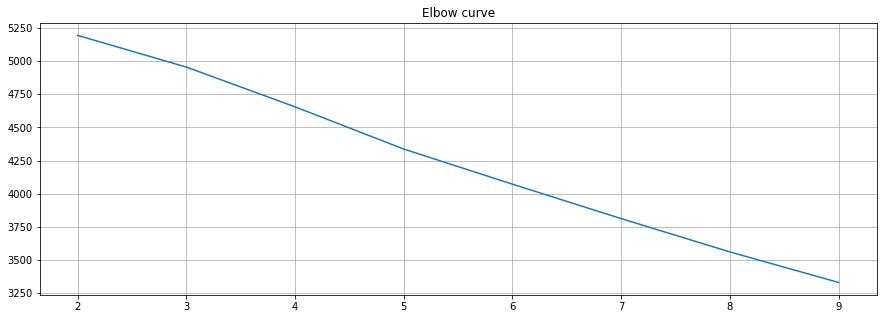

In [72]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [73]:
#Choose number of clusters
nb_clusters = 3
labels = KMeans(nb_clusters).fit(R).labels_
print(labels)
clusters_rating_mean = [R]

[1 0 2 1 0 1 1 0 0 0 0 2 1 0 0 1 2 2 1 2 2 2 2 0 1 2 2 1 0]


## Clusters_rating_mean is a matrix of size (M movies x C clusters), in each column there is the mean rating of the cluster

In [74]:
clusters_rating_mean = R.T@np.eye(nb_clusters)[labels]
for i in range(nb_clusters):
    clusters_rating_mean[:,i] = clusters_rating_mean[:,i]/np.count_nonzero(labels == i)

In [75]:
best_movies_by_cluster = np.argsort(-1*clusters_rating_mean, axis=0)

In [76]:
best_movies_by_cluster[:,1]

array([47, 36, 51, 25,  8, 35,  0,  2, 27, 46, 22, 41, 26, 56, 18, 11, 15,
        5, 58, 38, 24, 50, 10, 52, 23, 44, 54, 48, 45, 12,  6, 19, 40,  1,
       32, 21, 14, 34, 57, 17, 16, 49, 29,  7,  9, 33, 31, 43, 42, 20, 13,
       59,  4, 30, 37, 53, 55, 28,  3, 39], dtype=int64)

In [84]:
# We take the new user to be a mean between two users of cluster 0 for instance
new_user = np.mean(R[labels==0][:2],axis=0)

In [85]:
pointers_clusters = np.zeros(3)

In [86]:
def get_reward(movie, user) :
    return user[movie]

In [87]:
def UCB(cluster_index, delta, new_user, mu, T):
    if T[cluster_index] == 0:
        return 100000
    else:
        return mu[cluster_index] + np.sqrt(2 * np.log(1/delta)/T[cluster_index])

In [88]:
def UCB_tot(n, new_user, delta, best_movies_by_cluster, k):
    X = np.zeros(n) ##Réalisations (X_t)_t
    T = np.zeros(k, dtype = int) ##T[i] = nb de fois où i a été tiré
    arms_mat = np.zeros((n,k))
    mu = np.zeros(k) ##mu[i] = moyenne empirique de i

    A = np.zeros(n, dtype = int)
    
    for t in range(n):
        all_A_t = np.zeros(k)
        for i in range(k):
            all_A_t[i] = UCB(i, delta, new_user, mu, T) ##On calcul UCB_i pour tous les bras
        A[t] = np.argmax(all_A_t) ##On prend le bras qui a le UCB_i le plus haut
        print(T)
        movie = best_movies_by_cluster[:,A[t]][T[A[t]]]
        X[t] = get_reward(movie,new_user) ##On génère X_t la réalisation à partir du bras choisi
        T[A[t]] += 1 ##Le bras i a été tiré une fois de plus
        arms_mat[t, A[t]] = X[t] ##On stock la valeur de la réalisation dans une matrice
        mu[A[t]] = 1/T[A[t]] * sum(arms_mat[:, A[t]]) ##On update la moyenne empirique
#         Rn[t] = (t+1)*mu_star - T@mu ##On calcul le regret à l'instant t
    return X, A, mu

In [91]:
n = 5
delta = 1/(n**2)

X_t, arms, mu= UCB_tot(n, new_user, delta, best_movies_by_cluster, nb_clusters)

[0 0 0]
[0 0 0]
[1 0 0]
[1 1 0]
[1 1 1]
[2 1 1]


In [92]:
mu

array([3.16666667, 2.5       , 0.5       ])